In [2]:
import os
import os.path as op
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import sklearn
import patsy
from scipy.optimize import minimize
from sklearn import linear_model
import multiprocessing
import random
%matplotlib inline

In [3]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
exp_order = exp_order.set_index(['exp','run']).sort_index()

subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

order_dict_reverse_exp = {}
for exp in ['sim','ser']:
    order_dict = order_dict_exp[exp]
    order_dict_reverse = {val:key for key,val in zip(order_dict.keys(),order_dict.values())}
    order_dict_reverse[10] = None
    if exp == 'ser':
        order_dict_reverse[1] = None
        order_dict_reverse[4] = None
    order_dict_reverse_exp[exp] = order_dict_reverse.copy()

In [4]:
### process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

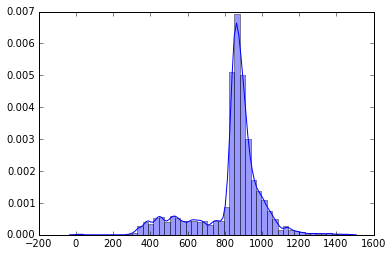

In [5]:
a = ser_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

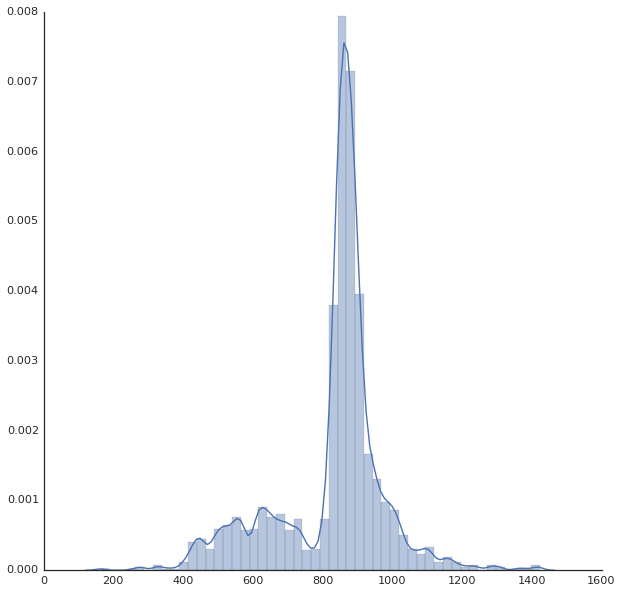

In [6]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")

a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);
sns.despine()
plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/RTs.png', dpi = 300)

# Load RSA data

In [7]:
cond_name_map = {'AB+':'b_plus','AC-':'c_minus','B-':'b_minus','C+':'c_plus'}
in_f = op.abspath('../rsa.csv')
rsa = pd.read_csv(in_f)

#rename things for convenience
rsa['trial1'] = [int(x.split('_')[1]) for x in rsa['cond1']]
rsa['trial2'] =[int(x.split('_')[1]) for x in rsa['cond2']]
rsa['cond1'] = [cond_name_map[x.split('_')[0]] for x in rsa['cond1']]
rsa['cond2'] =[cond_name_map[x.split('_')[0]] for x in rsa['cond2']]

run_map  = {1:'run1',2:'run2',3:'run3'}
rsa['run'] = [run_map[x] for x in rsa['run']]
rsa = rsa.rename(columns = {'resid':'corr', 'region':'mask'})

#make symmetric for easier indexing
rsa2 = rsa.copy()
rsa2['cond1'] = rsa['cond2']
rsa2['cond2'] = rsa['cond1']
rsa2['trial1'] = rsa['trial2']
rsa2['trial2'] = rsa['trial1']
rsa = pd.concat([rsa,rsa2])

# #preprocess a bit
rsa.loc[rsa['corr'] == 1,'corr'] = 0 #set diaganol from 1 to 0 (isnt used)

# #make hierarchical
# rsa = rsa.set_index(['mask','sub','run','cond1','cond2','trial1','trial2'])
rsa = rsa.set_index(['mask','sub','run','trial1','trial2','cond1','cond2'])
rsa = rsa.loc['yeo17_ifs']
rsa = rsa.sort_index()

In [8]:
overlapiness = {'sub':[],'run':[],'trial':[],'overlapiness':[]}

for sub in subjects:
    nruns = len(set(rsa.loc[sub].index.get_level_values(0)))
    for run in range(1,nruns+1):
        run = 'run' + str(run)
        for t in range(10):
            overlap = [ rsa.loc[(sub,run,t,t,'b_minus','b_plus'),'corr'],  #bplus b_minus
                       rsa.loc[(sub,run, t,t,'c_minus','b_plus'),'corr'], #bplus cminus
                        rsa.loc[(sub,run, t,t,'c_minus','c_plus'),'corr']] #cplus cminus
            non_overlap = [ rsa.loc[(sub,run, t,t,'b_minus','c_plus'),'corr'], #cplus bminus
                       rsa.loc[(sub,run, t,t,'b_plus','c_plus'),'corr'], #cplus bplus
                         rsa.loc[(sub,run, t,t,'b_minus','c_minus'),'corr']] #cminus bminus

            scaled_diff = (np.mean(overlap) - np.mean(non_overlap))# / (np.mean(overlap) + np.mean(non_overlap))

            overlapiness['overlapiness'].append(scaled_diff)
            overlapiness['sub'].append(sub)
            overlapiness['run'].append(run)
            overlapiness['trial'].append(t)
overlapiness = pd.DataFrame(overlapiness)
overlapiness = overlapiness.set_index(['sub','run']).sort_index()

In [9]:
overlapiness['overlapiness'] = overlapiness['overlapiness'] + abs(overlapiness['overlapiness'].min())

In [10]:
#get nonparametric transformation (simply rank the trials)
for run in set(overlapiness.index):
    #get ranks
    o = overlapiness.loc[run,'overlapiness'].values
    temp = o.argsort()
    ranks = np.empty(len(o), int)
    ranks[temp] = np.arange(len(o))
    ranks = [(x + 1)/10.0 for x in ranks]
    
    overlapiness.loc[run,'rank'] = ranks
#     overlapiness.loc[run,'overlapiness'] = o / np.std(o)

overlapiness = pd.DataFrame(overlapiness.to_records()).set_index(['sub','run','trial']).sort_index()

In [11]:
def sigmoid(x,scale,b):
    return 1 / (1 + np.exp(-(x-b)*scale))

# RL  Models

### First define some general functions that will be reused across our algorithms

In [12]:
#the same data structures are utilized across algorithms
def build_data_structures(order_dict):
    V = {x:[0] for x in order_dict.keys()}
    delta = {x:[] for x in order_dict.keys()}
    index = {x:[] for x in order_dict.keys()}
    
    return V, delta, index

In [13]:
def update_data_structures(V, delta, index, trial_type, count, PE, new_V):
    delta[trial_type].append(PE) 
    V[trial_type].append(new_V) 
    
    count += 1
    index[trial_type].append(count)
    
    return V, delta, index, count

In [14]:
def do_rl(rew_trial,trial_type,V,alpha,n):
    rew = rew_trial[n]
    PE = rew - V[trial_type][-1] #compute PE
    new_V = V[trial_type][-1] + alpha * PE #calculate V for next trial

    return new_V, PE

### Now define each RL model

In [15]:
def standard_RL(trial_order,rew_trial,alpha,exp,sub_rsa,sub,run):
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

    return V, delta, index

In [16]:
def brain_RL(trial_order,rew_trial,rl_params,exp,sub_rsa,sub,run):
    
    alpha,omega = rl_params
    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    #set up storage structures
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)

    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #get trial specific overlapiness
            t = len(index[trial_type]) - 1
            o = overlapiness.loc[(sub,'run' + str(run),t),'overlapiness']
            
            #loop through other conditions and blend value update
            other_conds = [x for x in order_dict.keys() if x != trial_type]
            for other_cond in other_conds:
                if other_cond in trial_map[trial_type]: #only blend if share features
#                     o = rsa.loc[(sub,'run' + str(run),t,t,trial_type,other_cond),'corr']
                    new_V = V[other_cond][-1] + alpha * PE *o *omega
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
    return V, delta, index

In [17]:
def leak_RL(trial_order,rew_trial,rl_params,exp,sub_rsa,sub,run):
    
    alpha,omega = rl_params
    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    #set up storage structures
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)

    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #loop through other conditions and blend value update
            other_conds = [x for x in order_dict.keys() if x != trial_type]
            for other_cond in other_conds:
                if other_cond in trial_map[trial_type]: #only blend if share features
                    new_V = V[other_cond][-1] + alpha * PE * omega
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
    return V, delta, index

In [18]:
def null_RL():
    return None

# now fit models

In [19]:
##function for building dataframe of relevant data for each subject
def build_df_all_bothexp(num_runs, subjects):
    alpha = .1
    exp_list = ['ser','sim']
    predictors = {'exp':[],'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):
        for exp in exp_list:
            order_dict = order_dict_exp[exp]
            
            ##perform RL for the experimental condition
            event_order = exp_order.loc[exp]
    
            rew = exp_order.loc[(exp,i),'rew'].values
            tt = exp_order.loc[(exp,i),'trial_order'].values
            V, delta, index = standard_RL(tt,rew,alpha,exp,None,None,None)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

            for sub in subjects:

                #get rt data for this subject and run
                rts = rt_dict_exp[exp]
                rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

                ##update predictors dict
                for key in V.keys():
                    predictors['V'].extend(V[key])
                    predictors['PE'].extend(delta[key])
                    predictors['cond'].extend([key]*len(V[key]))
                    predictors['exp'].extend([exp]*len(V[key]))
                    predictors['subject'].extend([sub]*len(V[key]))
                    predictors['run'].extend(['run' + str(i)]*len(V[key]))
                    predictors['trial_index'].extend(index[key])
                    predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)
    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort_values(by = ['subject','run','trial_index']) #get predictors in proper order
    predictors = predictors.set_index(['exp', 'subject','run']).sort_index()

    predictors['rt'] = np.log(predictors['rt'])
#     horrible nasty code to set response indexing. Hopfully i will find something more elegant one day
    for exp in ['sim','ser']:
        for sub in subjects:
            for run in map(str,range(1,4)):
                sub_df = predictors.loc[(exp,sub,'run' + run)]

                response = ~np.isnan(sub_df.loc[:,'rt'])
                nresponses = len(sub_df.loc[response,'trial_index'].values)
                idx = range(nresponses)
                idx = scipy.stats.zscore(idx)

                sub_df.loc[response,'resp_index'] = idx
                predictors.loc[(exp,sub,'run' + run), 'resp_index'] = sub_df.loc[(exp,sub,'run' + run),'resp_index'].values

    #add condition to the hierarchy
    predictors.set_index('cond', append=True, inplace=True)
    predictors.reset_index(level='cond').sort_index()
    predictors = z_score_dataframe(predictors,exp_list)

    return predictors

In [20]:
#Z score dataframe
def z_score_dataframe(predictors,exps):
    for sub in subjects:
        for exp in exps:
            for i in range(1,num_runs+1):
                run = 'run' + str(i)

                #mean center each run
                vals = predictors.loc[(exp,sub,run),'rt'].values
                vals = (vals - np.nanmean(vals))/np.nanstd(vals)
                predictors.loc[(exp,sub,run),'rt'] = vals

                #Z-score trial index for each row
                predictors.loc[(exp,sub,run),'trial_index'] = scipy.stats.zscore(predictors.loc[(exp,sub,run),'trial_index'])
    return predictors

In [21]:
def set_params(RL_func, params):
    if RL_func.func_name == 'null_RL':        
        alpha = 0
        beta = [0]
#         beta = params[1:]
#         beta[-1] = 0 #set beta to 0
        rl_params = alpha
        RL_func = standard_RL
    elif RL_func.func_name in ['leak_RL','dumb_RL']:
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        omega = scipy.stats.logistic.cdf(params[1]) #blend rate, positive
        beta = params[2:]
        rl_params = (alpha,omega)
    elif RL_func.func_name == 'brain_RL':
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        omega = params[1] #blend rate, positive
#         scale = scipy.stats.logistic.cdf(params[2])#*20 #blend rate, positive
#         shift = scipy.stats.logistic.cdf(params[3])*4 - 2 #shift
        beta = params[2:]
        rl_params = (alpha,omega)
    else:
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        beta = params[1:]
        rl_params = alpha
        
    return RL_func, rl_params, beta

In [22]:
##returns loss for linear regression
def regress_all(params,predictors,sub_rsa,sub,runs,exp,RL_func,loss_quantity):
        
    ##Set up parameter specific stuff according to the RL function
    RL_func, rl_params, beta = set_params(RL_func,params)

    ##perform RL for the experimental condition
    for run in runs:
        i = int(run[-1]) #just run number
        run_order = exp_order.loc[('sim',i)]
        rew = run_order['rew'].values
        tt = run_order['trial_order'].values
        V, delta, index = RL_func(tt,rew,rl_params,exp,sub_rsa,sub,i)
        
        for key in V.keys():
            if len(runs) > 1:
                idx = (run,key)
            else:
                idx  = key
            predictors.loc[idx,'V'] = np.array(V[key][:-1])
    
    #build RL matrixes
#     yd,Xd = patsy.dmatrices("rt ~ resp_index + V",predictors,NA_action='drop')
    yd,Xd = patsy.dmatrices("rt ~ V",predictors,NA_action='drop')
    X = np.asarray(Xd)
    
    #drop intercept
    X = X[:,1:] 
    X = X - np.mean(X,0)
    y = np.array(map(float,np.asarray(yd)))
    y = y - np.mean(y)

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    r2 = scipy.stats.pearsonr(y_hat,y)[0]**2
    sigma = np.std(y - y_hat)

    ll = len(y) * np.log(1/(sigma *np.sqrt(2*np.pi))) - (1.0/(2*sigma**2))*(loss**2)
    ll = ll*-1
    
    if loss_quantity == 'r2':
        return r2
    elif loss_quantity == 'll':
        return ll

In [29]:
# #set up experiment specific variables
num_runs = 3
predictors = build_df_all_bothexp(num_runs,subjects)

a = pd.DataFrame(predictors.to_records())
# a.to_csv('/home/iballard/Dropbox/fd/rt_fitting/predictors.csv',index = False)


/home/iballard/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/iballard/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/iballard/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/numpy/co

In [29]:
# sub = 'fd_105'
# exp = 'sim'
# rl_alg = brain_RL
# params = [0,10,-1,-1]

# sub_predictors = predictors.loc[exp,sub]
# sub_rsa = rsa.loc[sub] #deepcopy for speed

# regress_all(params,sub_predictors,sub_rsa,sub,num_runs,exp,rl_alg,'ll')
# regress_all(params,train_predictors,train_rsa,sub,runs,exp,rl_alg,'ll')

In [24]:
def run_subjects(in_tuple):
    sub_id, exp, rl_alg, method, params = in_tuple

    #get subject specific data
    sub_predictors = predictors.loc[exp,sub_id].copy() #deepcopy for speed
    sub_rsa = rsa.loc[sub_id].copy() #deepcopy for speed
    runs = list(set(sub_predictors.index.get_level_values(0)))

    for test_run in runs:
        train_runs = [x for x in runs if x != test_run]
        num_runs = len(train_runs)

        #split dataframes by train/test
        train_predictors = sub_predictors.loc[train_runs].copy().sort_index()
        test_predictors = sub_predictors.loc[test_run].copy().sort_index()
        train_rsa = sub_rsa.loc[train_runs].copy().sort_index()
        test_rsa = sub_rsa.loc[test_run].copy().sort_index()

        #minimize
        minimizer_kwargs = {"method": method, 'args':(train_predictors,train_rsa,sub_id,train_runs,exp,
                                                        rl_alg,'ll')}
        try:
            #fit
            res = basinhopping(regress_all, params, minimizer_kwargs=minimizer_kwargs,niter=1)

            #predict
            test_LL = regress_all(res.x,test_predictors,test_rsa,sub,[test_run],exp,rl_alg,'ll')

            out_df = pd.DataFrame({'test_LL':test_LL,
                                   'train_LL':res.fun,
                                   'test_run':test_run,
                                   'alpha': scipy.stats.logistic.cdf(res.x[0]),
                                   'beta': res.x[-1],
                                   'trial_beta': res.x[-2],
                                   'sub':sub_id,
                                   'exp':exp,
                                   'rl_alg':rl_alg.func_name,
                                   'method':method},index = [0])
            out_f = op.abspath('../rt_fits/' + '_'.join((sub_id, exp, rl_alg.func_name, method, str(test_run))) + '.csv')
            out_df.to_csv(out_f,index = False)

        except:
            return (sub_id,exp,rl_alg,'Failed')
        
    return (sub_id,exp,rl_alg,'Success')


    

In [45]:
#define variables
exp = 'sim'
from scipy.optimize import basinhopping
# rl_params = {standard_RL:[0,0,0],
#              leak_RL:[0,0,0,0],null_RL:[0,0,0],
#             brain_RL:[0,0,0,0,0,0]}
rl_params = {null_RL:[0,0],leak_RL:[0,0,0],standard_RL:[0,0]}
rl_params = {brain_RL:[0,0,0]}

# rl_params = {brain_RL:[scipy.stats.logistic.ppf(.095),scipy.stats.logistic.ppf(.445),0,0,.9, -7.6]}

in_tuples = []
method = ['CG']

bad_subs = ['fd_122','fd_127','fd_133']
good_subs = [x for x in subjects if x not in bad_subs]
for sub in good_subs:
    for alg, params in rl_params.iteritems():
        for meth in method:
            in_tuples.append((sub, exp, alg ,meth,params))
subjects = good_subs
# run_subjects_l1so(in_tuples[1])

In [ ]:
pool = multiprocessing.Pool(34)
res = pool.map(run_subjects_l1so,in_tuples)
pool.terminate()
pool.join()

/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/iballard/anaconda/lib/python2.7/site-pac

In [101]:
# results = []
# for tup in in_tuples:
#     sub_id, exp, rl_alg, method, params = tup
#     #get subject specific data
#     sub_predictors = predictors.loc[exp,sub_id].copy() #deepcopy for speed
#     runs = list(set(sub_predictors.index.get_level_values(0)))
#     for test_run in runs:
#         out_f = op.abspath('../rt_fits/' + '_'.join((sub_id, exp, rl_alg.func_name, method, str(test_run))) + '.csv')
#         in_df = pd.read_csv(out_f)
#         in_df['sub'] = sub_id
#         results.append(in_df)
# results = pd.concat(results)

In [47]:
def minimize_func_l1so(params, predictors, rsa, subs, exp, RL_func, loss_quantity):
    
    all_ll = 0
    for sub in subs:
        sub_predictors = predictors.loc[exp,sub].copy().sort_index() #deepcopy for speed
        sub_rsa = rsa.loc[sub].copy().sort_index() #deepcopy for speed
        runs = list(set(sub_predictors.index.get_level_values(0)))
        
        ll = regress_all(params,sub_predictors,sub_rsa,sub,runs,exp,RL_func,loss_quantity)
        if not np.isnan(ll):
            all_ll = all_ll + ll
        
    return all_ll

In [48]:
def run_subjects_l1so(in_tuple):
    sub_id, exp, rl_alg, method, params = in_tuple

    other_subs = [x for x in subjects if x != sub_id]

    
    #minimize
    minimizer_kwargs = {"method": method, 'args':(predictors,rsa,other_subs,exp,
                                                    rl_alg,'ll')}
    try:
        #fit
        res = basinhopping(minimize_func_l1so, params, minimizer_kwargs=minimizer_kwargs,niter=1)

        #predict
        test_LL = minimize_func_l1so(res.x, predictors, rsa, [sub_id], exp, rl_alg, 'll')

        out_df = pd.DataFrame({'test_LL':test_LL,
                               'train_LL':res.fun,
                               'alpha': scipy.stats.logistic.cdf(res.x[0]),
                               'beta': res.x[-1],
    #                                    'trial_beta': res.x[-2],
                               'sub':sub_id,
                               'exp':exp,
                               'rl_alg':rl_alg.func_name,
                               'method':method},index = [0])
        out_f = op.abspath('../rt_fits/l1so' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
        out_df.to_csv(out_f,index = False)

    except:
        return (sub_id,exp,rl_alg,'Failed')

    return (sub_id,exp,rl_alg,'Success')


    

In [31]:
results = []
for tup in in_tuples:
    sub_id, exp, rl_alg, method, params = tup
    #get subject specific data
    sub_predictors = predictors.loc[exp,sub_id].copy() #deepcopy for speed
    runs = list(set(sub_predictors.index.get_level_values(0)))
    for test_run in ['run1']:
        out_f = op.abspath('../rt_fits/l1so' + '_'.join((sub_id, exp, rl_alg.func_name, method)) + '.csv')
        in_df = pd.read_csv(out_f)
        in_df['sub'] = sub_id
        results.append(in_df)
results = pd.concat(results)
results = results[results['sub'] != 'fd_122']
# results[results['rl_alg'] == 'brain_RL'].mean()['test_LL']

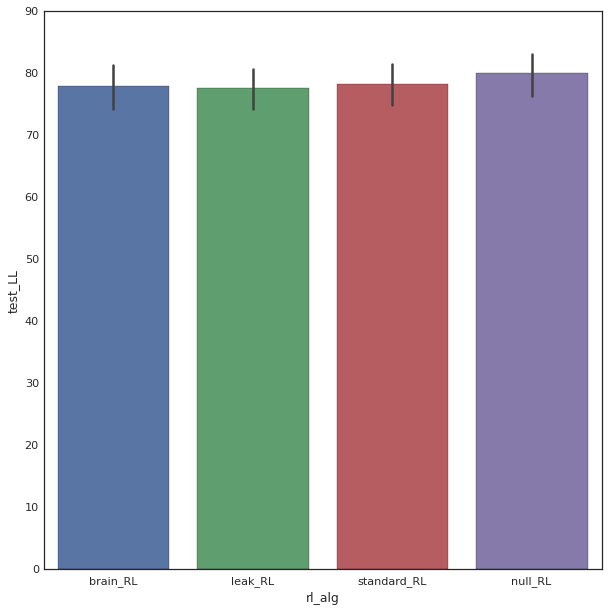

In [137]:
sns.barplot(x = 'rl_alg', y = 'test_LL', data = results, estimator=np.mean)

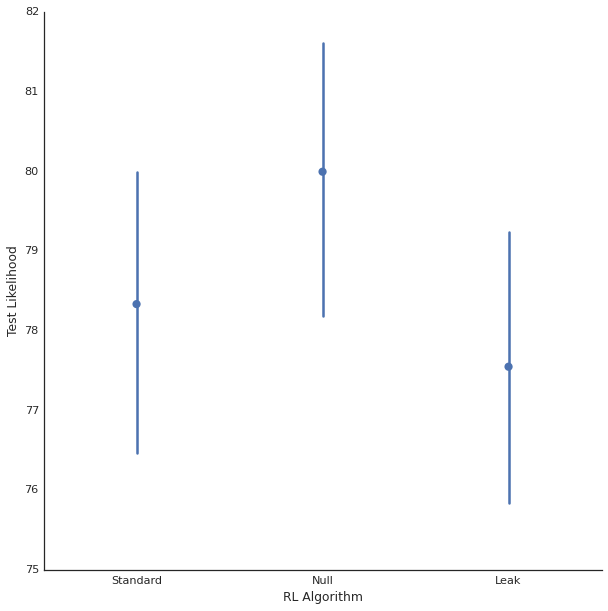

In [43]:
alg_map = {'standard_RL':'Standard', 'null_RL':'Null','leak_RL':'Leak'}
results['RL Algorithm'] = [alg_map[x] for x in results['rl_alg']]
sns.set_context('paper',font_scale = 1.4)

sns.pointplot(x = 'RL Algorithm', y = 'test_LL', data = results, join = False, ci = 68)
plt.ylabel('Test Likelihood')
sns.despine()
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/model_comparison.svg', 
            dpi = 300,
           bbox_inches = 'tight')

In [44]:
bad_subs = ['fd_122']
for s in bad_subs:
    results = results[results['sub'] != s]
r = results.groupby(['rl_alg','sub']).mean().dropna()
diff = r.loc['standard_RL','test_LL'] - r.loc['leak_RL','test_LL']
scipy.stats.ttest_1samp(diff.values,0)

Ttest_1sampResult(statistic=2.4645003192351598, pvalue=0.0201208172544028)

In [143]:
bad_subs = ['fd_122']
for s in bad_subs:
    results = results[results['sub'] != s]
r = results.groupby(['rl_alg','sub']).mean().dropna()
diff = r.loc['brain_RL','test_LL'] - r.loc['standard_RL','test_LL']
scipy.stats.ttest_1samp(diff.values,0)

Ttest_1sampResult(statistic=-1.5359294892984239, pvalue=0.1357798558870589)

In [145]:
r

alpha      beta    test_LL     train_LL
rl_alg      sub                                               
brain_RL    fd_104  0.418639 -1.045616  55.701450  2201.092602
            fd_105  0.414705 -0.993569  80.640542  2176.025417
            fd_107  0.401640 -1.086707  92.574646  2164.333834
            fd_108  0.412670 -1.062857  90.034707  2166.898348
            fd_109  0.400447 -1.099890  93.763292  2163.255723
            fd_110  0.401555 -0.991634  75.621407  2181.141675
            fd_112  0.401518 -1.027970  83.821458  2172.892530
            fd_113  0.411943 -1.012623  83.166093  2173.472142
            fd_114  0.392272 -1.009032  78.402381  2178.402840
            fd_115  0.408638 -1.033488  84.997433  2171.663659
            fd_117  0.400455 -1.007148  79.462103  2177.280267
            fd_118  0.403444 -0.978548  77.188045  2179.643777
            fd_119  0.408014 -1.013469  62.309907  2194.436250
            fd_123  0.395840 -1.027674  81.854909  2174.829969
            fd_124  0.410116 -0.983338  70.871769  2185.835903
            fd_126  0.419018 -0.965049  77.270499  2179.463259
            fd_128  0.423390 -0.964629  79.998418  2176.761850
            fd_129  0.416960 -0.984172  53.484345  2203.223753
            fd_130  0.422629 -1.008190  82.495747  2174.201266
            fd_132  0.415331 -1.023301  76.167436  2180.504229
            fd_135  0.396540 -1.031575  81.826007  2174.867269
            fd_136  0.403580 -1.029995  76.325506  2180.327587
            fd_137  0.410432 -0.990200  79.135632  2177.644794
            fd_138  0.420677 -0.954332  77.776699  2179.010018
            fd_140  0.409362 -1.012257  81.231715  2175.404182
            fd_141  0.410250 -1.014597  58.560019  2198.175791
            fd_144  0.417367 -1.010377  83.015179  2173.659841
            fd_147  0.424313 -0.978335  81.702246  2175.022495
            fd_148  0.423748 -1.003184  83.352149  2173.338159
leak_RL     fd_104  0.407959 -1.427758  54.869170  2188.262667
...                      ...       ...        ...          ...
null_RL     fd_148  0.500000  0.000000  85.136312  2234.828189
standard_RL fd_104  0.586919 -0.738964  53.779962  2213.378092
            fd_105  0.594701 -0.696880  81.222700  2185.877836
            fd_107  0.572847 -0.765900  91.364077  2175.959004
            fd_108  0.587275 -0.764661  90.372660  2177.011537
            fd_109  0.572463 -0.775978  92.434862  2174.997812
            fd_110  0.587929 -0.678875  75.774951  2191.425992
            fd_112  0.555788 -0.739479  84.491871  2182.673610
            fd_113  0.572049 -0.721871  83.102037  2183.994100
            fd_114  0.568727 -0.686413  78.262723  2188.977866
            fd_115  0.584434 -0.727330  85.028375  2182.072415
            fd_117  0.599737 -0.681329  79.529008  2187.631779
            fd_118  0.610818 -0.661884  77.897250  2189.392460
            fd_119  0.591172 -0.727944  63.925044  2203.192285
            fd_123  0.571570 -0.714800  82.030395  2185.070174
            fd_124  0.596620 -0.681522  71.148352  2196.014617
            fd_126  0.614387 -0.677113  78.594458  2188.595197
            fd_128  0.612220 -0.698725  82.837997  2184.293697
            fd_129  0.583152 -0.715302  55.332936  2211.748153
            fd_130  0.594898 -0.724195  82.757733  2184.357062
            fd_132  0.569765 -0.724693  76.391864  2190.710595
            fd_135  0.572248 -0.705482  80.803205  2186.315675
            fd_136  0.579008 -0.715486  75.775781  2191.308636
            fd_137  0.584668 -0.678441  78.268797  2188.947685
            fd_138  0.596339 -0.684459  79.700994  2187.446324
            fd_140  0.584356 -0.711479  81.142542  2185.938616
            fd_141  0.578404 -0.738192  60.319219  2206.814899
            fd_144  0.598347 -0.706520  82.896775  2184.194976
            fd_147  0.580966 -0.719285  83.432220  2183.651657
            fd_148  0.606148 -0.704247  83.188285  2183.922934

[116 rows x 4 columns]